In [7]:
import os
import gc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2, ResNet50
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.applications import EfficientNetB0

import cv2
#import torch

#device = "cuda" if torch.cuda.is_available() else "cpu"
#print("using {} device".format(device))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
#print('Count of using GPUs:', torch.cuda.device_count())

In [15]:
categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
dir_c = './train_img_aug(150)/cafe_aug/'
dir_r = './train_img_aug(150)/restaurant_aug/'

def load_img(dir):                # 이미지를 불러온 뒤 X로 반환 , 해당 폴더명과 같은 라벨 Y 반환 

    X = []
    Y = []

    for index , category in enumerate(categories):
        label = index + 1
        img_dir = dir + category +'/'

        for top, directory , f  in os.walk(img_dir):
            for filename in f:
                img = cv2.imread(img_dir + filename , cv2.IMREAD_COLOR)
                img = cv2.resize(img,(200,200), cv2.INTER_AREA) # 1440 x 1440 x 3은 너무 크기 때문에 360 x 360 x 3으로 변환
                #img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X.append(img)
                Y.append(label)

    return X , Y

In [16]:
img_c ,label_c = load_img(dir_c) # 각각의 이미지를 폴더에서 불러움
img_r ,label_r = load_img(dir_r)

In [17]:
img_c = np.array(img_c)        #이미지 수정 및 병합을 위해 numpy형식의 배열로 바꿈
label_c = np.array(label_c)
img_r = np.array(img_r)
label_r = np.array(label_r)

In [18]:
label_c.shape

(1500,)

In [19]:
label_r += 10           # cafe 와의 라벨 차이를 위해 restaurant는 +10 ( 총 0 ~19 번까지의 라벨 존재)

In [20]:
img_c.shape

(1500, 200, 200, 3)

In [21]:
X = np.vstack([img_c,img_r]) # 카페와 식당의 이미지 병합

In [22]:
Y = np.hstack([label_c,label_r]) # 카페와 식당의 라벨 병합

In [23]:
X.shape

(3000, 200, 200, 3)

In [24]:
X = np.array(X, dtype="float32") / 255.0    # 분류 정확도를 위한 정규화 ( 0 ~ 255 -> 0 ~ 1)

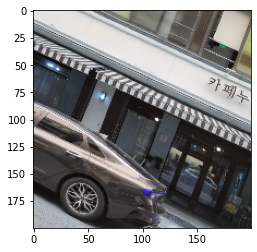

In [25]:
plt.imshow(X[0]) # 360 x 360 x 3으로 진행해도 이미지의 큰 수정은 없음

In [26]:
le = LabelBinarizer() # 원핫 인코딩
Y = le.fit_transform(Y)
print(Y.shape)
print(Y[:10])


(3000, 20)
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size = 0.20 ,stratify=Y, random_state=42) # 학습 / 테스트 스플릿
X_train , X_val , Y_train , Y_val = train_test_split(X_train,Y_train , test_size = 0.20 , stratify = Y_train , random_state = 42)
# 학습 / 검증 스플릿 ( 추후 실전 정확도는 test로 , 학습에 대한 검증은 validation으로 하기 위함)

In [28]:
print(X_train.shape)
print(X_val.shape)

(1920, 200, 200, 3)
(480, 200, 200, 3)


In [29]:
Y_train[:10]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
from keras.preprocessing.image import ImageDataGenerator # 데이터의 추가 증강을 위한 테크닉
from skimage import io
aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

In [33]:
batch_size = 4 # 32개의 배치로 학습
epochs = 50 # 50 에포크 진행

In [51]:
enet = ResNet50(
        input_shape=(200,200,3), # 입력 이미지와 맞춤 (224, 224, 3이 이용할 수 있는 데이터의 천장)
        weights=None,
        include_top=False
    )

model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(20, activation='softmax') # 총 20개 분류이기 때문에 Dense(20)
    ])


#callbacks = [(monitor='val_accuracy', mode='max')] 

early = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose = 1) # 20번 반복중 정확도가 최고치일때 early stop

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

SyntaxError: invalid syntax (3362203392.py, line 14)

In [52]:
history = model.fit(
    aug.flow(X_train, Y_train, batch_size=batch_size),
    epochs = epochs, 
    validation_data=(X_val, Y_val),
    verbose=1,
    #callbacks=[callbacks, early])
    callbacks=[early])

Epoch 1/50
480/480 [==============================] - 347s 716ms/step - loss: 3.1731 - accuracy: 0.1870 - val_loss: 6.9594 - val_accuracy: 0.0812
Epoch 2/50
480/480 [==============================] - 407s 848ms/step - loss: 1.9171 - accuracy: 0.4380 - val_loss: 15.3759 - val_accuracy: 0.2250
Epoch 3/50
480/480 [==============================] - 1353s 3s/step - loss: 1.2471 - accuracy: 0.6193 - val_loss: 4.1359 - val_accuracy: 0.2958
Epoch 4/50
480/480 [==============================] - 349s 728ms/step - loss: 0.9137 - accuracy: 0.7151 - val_loss: 0.6253 - val_accuracy: 0.8188
Epoch 5/50
480/480 [==============================] - 344s 716ms/step - loss: 0.6557 - accuracy: 0.7990 - val_loss: 3.0163 - val_accuracy: 0.4938
Epoch 6/50
480/480 [==============================] - 338s 705ms/step - loss: 0.5200 - accuracy: 0.8344 - val_loss: 1.3752 - val_accuracy: 0.6313
Epoch 7/50
480/480 [==============================] - 355s 739ms/step - loss: 0.4189 - accuracy: 0.8682 - val_loss: 1.6164 - 

KeyboardInterrupt: 